In [1]:
import tensorflow.keras as keras
keras.__version__

'2.3.0-tf'

## loading Jena weather dataset

In [2]:
import os

data_dir = 'C:/data/jena_climate/'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

## parsing data

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))  #exclude date feature
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]  #exclude date feature
    float_data[i, :] = values

## normalizing data

In [4]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

## preparing training, validation, and test generators

In [5]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1  #for last segment of data: limit index.
    i = min_index + lookback  #current time step from which to look back in the past and ahead in the future.
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))  #[i, i + batch_size]
            i += len(rows)  #i = i + batch_size

        samples = np.zeros((len(rows),    #batch_size
                           lookback // step,  #sample_per_past_period: 24hours x 10days = 240 samples in past 10 days
                           data.shape[-1]))  #feature_size = 14
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):  #number of elements = batch_size:
            indices = range(rows[j] - lookback, rows[j], step)  #past: [i - lookback, i], for i in {i,...,i+batch_size}; caution: refer to i before being updated to i = i + batch_size
            samples[j] = data[indices]  #sample_per_past_period data points, each 14 features
            targets[j] = data[rows[j] + delay][1]  #future: target temperature in i + delay time steps.
        yield samples, targets

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

#number of steps to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size  #start from 200001 + lookback

#number of steps to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size  #start from 300001 + lookback

## training base GRU model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(8, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=60,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/60
500/500 [==============================] - 125s 250ms/step - loss: 0.3679 - val_loss: 0.2770
Epoch 2/60
500/500 [==============================] - 129s 258ms/step - loss: 0.2943 - val_loss: 0.2727
Epoch 3/60
500/500 [==============================] - 125s 250ms/step - loss: 0.2910 - val_loss: 0.2711
Epoch 4/60
500/500 [==============================] - 126s 253ms/step - loss: 0.2864 - val_loss: 0.2709
Epoch 5/60
500/500 [==============================] - 123s 246ms/step - loss: 0.2863 - val_loss: 0.2711
Epoch 6/60
500/500 [==============================] - 123s 246ms/step - loss: 0.2833 - val_loss: 0.2685
Epoch 7/60
500/500 [==============================] - 124s 248ms/step - loss: 0.2827 - val_loss: 0.2658
Epoch 8/60
500/500 [==============================] - 122s 244ms/step - loss: 0.2809 - val_loss: 0.2664
Epoch 9/60
500/500 [==============================] - 126s 252ms/step - loss: 0.2804 - val_l

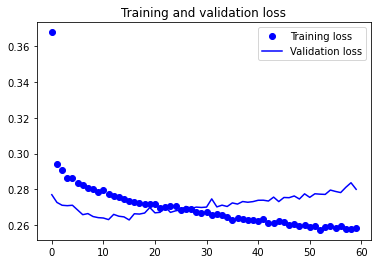

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [9]:
#val loss minimum at second epoch

In [10]:
np.argmin(val_loss)+1

16

In [11]:
val_loss[np.argmin(val_loss)]

0.26286476850509644

In [12]:
#baseline: denormalized average absolute error: 2.57°C

In [13]:
celsius_mae = val_loss[np.argmin(val_loss)] * std[1]

In [14]:
round(celsius_mae,2)

2.33